# Grad-CAM Visualization Demo

This notebook shows how to generate Grad-CAM heatmaps for Morph-Net predictions using the training/evaluation pipeline. Update the configuration cell below with your local dataset paths and a trained checkpoint from `output/`.

## Setup
The demo relies on the regular code base (no extra notebooks). Ensure you have already trained a model so that `CHECKPOINT_PATH` points to a valid `.pt` file and that the PanNuke folds are available under `data/PanNuke`.

In [1]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

from dataset_pannuke import get_postprep_data
from dataset_utils import get_transforms
from test_utils import load_checkpoint
from gradcam import GradCAM


In [2]:
# User configuration
DATA_DIR = Path("data/PanNuke")
CHECKPOINT_PATH = Path("output/pannuke_demo-split1-densenet-area-major_axis_length-minor_axis_length-perimeter-eccentricity-scaled.pt")
SPLIT_NO = 1        
IMAGE_INDEX = 0  # pick any patch from the selected fold
CLASS_ID = 0     # 0: Neoplastic, 1: Inflammatory, 2: Connective, 3: Epithelial
FEATURE_NAME = "total_area"  # must exist in checkpoint['feature_names']
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
model, checkpoint = load_checkpoint(CHECKPOINT_PATH, DEVICE)
model.eval()
config = checkpoint.get("config", {})
feat_names = checkpoint.get("feature_names")
if feat_names is None:
    raise ValueError("Checkpoint is missing feature names.")

nclasses = int(config.get("nclasses", 4))
if FEATURE_NAME not in feat_names:
    raise ValueError(f"{FEATURE_NAME} is not part of the model targets: {feat_names}")
feature_index = feat_names.index(FEATURE_NAME)
target_index = feature_index * nclasses + CLASS_ID
print(f"Target index for Grad-CAM: {target_index}")


Target index for Grad-CAM: 4


/home/u2058145/anaconda3/envs/tiatoolbox-dev/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/u2058145/anaconda3/envs/tiatoolbox-dev/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
fold = get_postprep_data(SPLIT_NO, data_dir=DATA_DIR)
raw_image = fold["imgs"][IMAGE_INDEX]
transform = get_transforms("val")
input_tensor = transform(image=raw_image)["image"].unsqueeze(0).to(DEVICE)
print(f"Input tensor shape: {input_tensor.shape}")


Loading PanNuke fold 1 from data/PanNuke
  imgs shape:   (2656, 256, 256, 3)
  types shape:  (2656,)
  masks shape:  (2656, 256, 256, 4)
  converted masks.npy -> 4 classes (Neoplastic/Inflammatory/Connective/Epithelial)
Input tensor shape: torch.Size([1, 3, 256, 256])


In [5]:
model_dict = {"type": config.get("base_model", "densenet"), "layer_name": "base_model", "arch": model}
gradcam = GradCAM(model_dict, target_layer=model.base_model)
cam, logits = gradcam(input_tensor, class_idx=target_index)
heatmap = cam.squeeze().cpu().numpy()
if heatmap.max() > heatmap.min():
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
else:
    heatmap = np.zeros_like(heatmap)
print("Logit value for the selected output:", float(logits[0, target_index]))


/home/u2058145/anaconda3/envs/tiatoolbox-dev/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/home/u2058145/anaconda3/envs/tiatoolbox-dev/lib/python3.8/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Logit value for the selected output: 0.07551804184913635


/home/u2058145/anaconda3/envs/tiatoolbox-dev/lib/python3.8/site-packages/torch/nn/functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


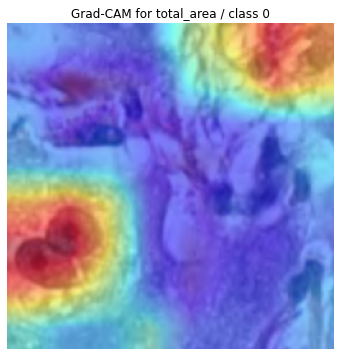

In [6]:
plt.figure(figsize=(6, 6))
plt.imshow(raw_image)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title(f"Grad-CAM for {FEATURE_NAME} / class {CLASS_ID}")
plt.axis("off")
plt.show()
